In [ ]:
#Gas-phase calculations

#Unit cell obtained from https://materialsproject.org/materials/mp-1190/ and structured Minimized in Avogadro

import psi4

psi4.set_memory(4250000000)
psi4.set_num_threads(4)

molecule = psi4.geometry(""" 0 1
Zn    0.000000    0.000000    0.000000
Zn    2.030224    1.172150    3.315342
Zn    2.030224    3.516451    0.000000
Zn    4.060448    4.688601    3.315342
Zn    4.060448    0.000000    0.000000
Zn    6.090672    1.172150    3.315342
Zn    6.090672    3.516451    0.000000
Zn    8.120895    4.688601    3.315342
Se    6.090672    3.516451    2.486506
Se   -2.030224   -1.172150   -0.828835
Se    0.000000    0.000000    2.486506
Se    0.000000    2.344301   -0.828835
Se    2.030224   -1.172150   -0.828835
Se    2.030224    1.172150    5.801848
Se    2.030224    3.516451    2.486506
Se    4.060448    0.000000    2.486506
Se    2.030224    5.860751   -0.828835
Se    4.060448    2.344301   -0.828835
Se    4.060448    4.688601    5.801848
Se    4.060448    7.032902    2.486506
Se    6.090672   -1.172150   -0.828835
Se    6.090672    1.172150    5.801848
Se    8.120895    0.000000    2.486506
Se    6.090672    5.860751   -0.828835
Se    8.120895    2.344301   -0.828835
Se    8.120895    4.688601    5.801848
Se    8.120895    7.032902    2.486506
Se   10.151119    3.516451    2.486506
""", name= "ZnSe Primitive Cell")


psi4.set_options({
 "save_jk" : True,
})

e, wfn = psi4.energy("B3LYP/aug-cc-pVDZ", return_wfn=True, molecule=molecule)


  Memory set to   3.958 GiB by Python driver.
  Threads set to 4 by Python driver.

Scratch directory: /tmp/

*** tstart() called on Bedabratas-MacBook-Air.local
*** at Sat Jul  9 10:53:11 2022

   => Loading Basis Set <=

    Name: AUG-CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-8  entry ZN         line  2691 file /opt/miniconda3/share/psi4/basis/aug-cc-pvdz.gbs 
    atoms 9-28 entry SE         line  3217 file /opt/miniconda3/share/psi4/basis/aug-cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RKS Reference
                        4 Threads,   4053 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C1

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

     

In [7]:
HOMO = wfn.epsilon_a_subset('AO', 'ALL').np[wfn.nalpha()]
LUMO = wfn.epsilon_a_subset('AO', 'ALL').np[wfn.nalpha() + 1]
print(HOMO, LUMO, e)

-0.05010635170539055 -0.007027220470652867 -2139.657324339805


In [8]:
band_gap=(LUMO-HOMO)*27.2114 

print(band_gap)

1.1722434716809411


In [114]:
#Estimate nanoparticle volume and calculate radius of nanoparticle assuming it's enclosed in a sphere

import deepchem
import numpy as np

#from https://github.com/deepchem/deepchem/blob/master/deepchem/utils/rdkit_utils.py

import os
import logging
import itertools
import numpy as np
from io import StringIO
from deepchem.utils.pdbqt_utils import pdbqt_to_pdb
from deepchem.utils.pdbqt_utils import convert_mol_to_pdbqt
from deepchem.utils.pdbqt_utils import convert_protein_to_pdbqt
from deepchem.utils.geometry_utils import compute_pairwise_distances
from deepchem.utils.geometry_utils import compute_centroid
from deepchem.utils.fragment_utils import MolecularFragment
from deepchem.utils.fragment_utils import MoleculeLoadException
from typing import Any, List, Tuple, Set, Optional, Dict
from deepchem.utils.typing import OneOrMany, RDKitMol

logger = logging.getLogger(__name__)


def get_xyz_from_mol(mol):
  """Extracts a numpy array of coordinates from a molecules.
  Returns a `(N, 3)` numpy array of 3d coords of given rdkit molecule
  Parameters
  ----------
  mol: rdkit Molecule
    Molecule to extract coordinates for
  Returns
  -------
  Numpy ndarray of shape `(N, 3)` where `N = mol.GetNumAtoms()`.
  """
  xyz = np.zeros((mol.GetNumAtoms(), 3))
  conf = mol.GetConformer()
  for i in range(conf.GetNumAtoms()):
    position = conf.GetAtomPosition(i)
    xyz[i, 0] = position.x
    xyz[i, 1] = position.y
    xyz[i, 2] = position.z
  return (xyz)

import rdkit
from rdkit import Chem


#Crystal imported from Avogadro software and converted to mol file with OpenBabel

m= Chem.MolFromMolFile('small_molecule.mol')

coords= get_xyz_from_mol(m)

from scipy.spatial import ConvexHull

hull = ConvexHull(coords)


cell_volume = hull.volume #This is in cubic Angstroms
radius_0=(3/4*(cell_volume/np.pi))**(1/3)

In [116]:
radius_0

3.2184048090163566

Text(0, 0.5, 'Band-Gap(eV)')

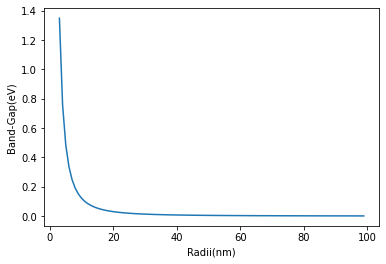

In [47]:
# From the paper Electron-electron and electron-hole interactions in small semiconductor crystallites : The size dependence of the lowest excited electronic state
#Bamd gap/HOMO-LUMO gap varies as 1/R^2 with the nanoparticle radius

#http://fizyka.umk.pl/~wj/EDU/Pracownia_Projektowa/brus.pdf


def gap_as_a_function_of_radius(R):
    
    res=((band_gap)*(radius_0)**2)/(R**2)      #converting gap to electron volts
    return res


import matplotlib.pyplot as plt

radii=np.arange(3,100)     #generating radii for particle sizes 10 nm to 100 nm
gaps=[gap_as_a_function_of_radius(R) for R in radii]
plt.plot(radii,gaps)
plt.xlabel("Radii(nm)")
plt.ylabel("Band-Gap(eV)")

In [48]:
gap_as_a_function_of_radius(10)

0.12142249702432294

In [29]:
from rdkit.Chem import Descriptors
m=Chem.MolFromMolFile('small_molecule.mol')
logp=Descriptors.MolLogP(m)

In [30]:
#Load Hydration Free Energy Model
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import sklearn
import joblib

loaded_model = joblib.load('hydration_model_new.sav')

X = []

arr = np.zeros((0,))
fp = AllChem.GetMorganFingerprintAsBitVect(m, 2)
DataStructs.ConvertToNumpyArray(fp, arr)
X.append(arr)

HE=loaded_model.predict(X)[0]

In [41]:
#Eqtn 5 https://arpgweb.com/pdf-files/ajc3(8)72-77.pdf

dielectric_constant_solute = 6.920*logp+(-284.010)*LUMO+ (-3.184)*HE+(107.910)*HOMO+ ( -3.748)*dipole

In [42]:
dielectric_constant_solute

6.230092495057949

In [43]:
#Calculate ground-state exciton energy as a function of nanoparticle radii

def exciton_energy(R):
    coulomb_interaction=(1.8*1.60217663/(R*(dielectric_constant_solute)))                
    coul_ev=(coulomb_interaction)
    res=gap_as_a_function_of_radius(R)-coul_ev
    return res

In [49]:
exciton_energy(3)

1.1948384214803234

Text(0, 0.5, 'Exciton Energies(eV)')

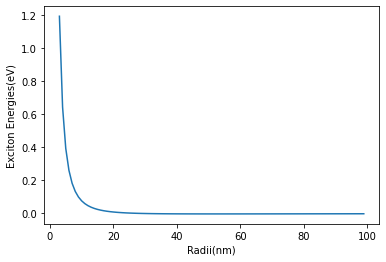

In [46]:
import matplotlib.pyplot as plt

radii=np.arange(3,100)     #generating radii for particle sizes 10 nm to 100 nm
gaps=[exciton_energy(R) for R in radii]
plt.plot(radii,gaps)
plt.xlabel("Radii(nm)")
plt.ylabel("Exciton Energies(eV)")

Text(0, 0.5, 'gap-exciton differences(eV)')

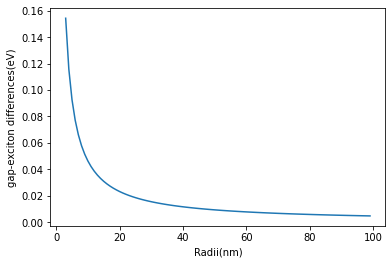

In [51]:
import matplotlib.pyplot as plt

radii=np.arange(3,100)     #generating radii for particle sizes 10 nm to 100 nm
gaps=[gap_as_a_function_of_radius(R)-exciton_energy(R) for R in radii]
plt.plot(radii,gaps)
plt.xlabel("Radii(nm)")
plt.ylabel("gap-exciton differences(eV)")

In [52]:
from rdkit import Chem
from pygamess import Gamess
from pygamess.utils import rdkit_optimize
m= rdkit_optimize("C[C@@H]1ON[C@@H]([C@@H]2CCCC[C@@H]2Cl)[C@@H]1C(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)O)C(C)(C)S[C@H]12")
g = Gamess(num_cores=1)
g.pcm_type("water")
r = g.run(m)

Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


In [53]:
from pygamess import Gamess
from pygamess.utils import rdkit_optimize
m = rdkit_optimize("C[C@@H]1ON[C@@H]([C@@H]2CCCC[C@@H]2Cl)[C@@H]1C(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)O)C(C)(C)S[C@H]12")
g = Gamess()
r2 = g.run(m)

Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


In [54]:
fraction_gas_phase=band_gap/((r2.LUMO-r2.HOMO)*27.2114)
band_gap_solvated=fraction_gas_phase*((r.LUMO-r.HOMO)*27.2114)

In [55]:
fraction_gas_phase

5.190256775269617

In [56]:
def gap_as_a_function_of_radius_solvated(R):
    
    res=((band_gap_solvated)*(radius_0)**2)/(R**2)      #converting gap to electron volts
    return res

In [57]:
gap_as_a_function_of_radius_solvated(3)

1.2028466907362623

Text(0, 0.5, 'Band-Gap(eV)')

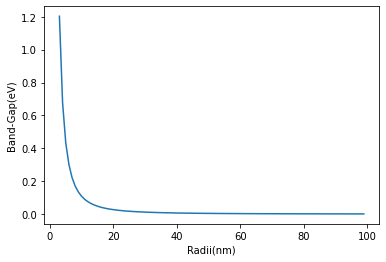

In [58]:
import matplotlib.pyplot as plt

radii=np.arange(3,100)     #generating radii for particle sizes 10 nm to 100 nm
gaps=[gap_as_a_function_of_radius_solvated(R) for R in radii]
plt.plot(radii,gaps)
plt.xlabel("Radii(nm)")
plt.ylabel("Band-Gap(eV)")

In [64]:
#Calculate ground-state exciton energy as a function of nanoparticle radii

def exciton_energy_solvated(R):
    coulomb_interaction=(1.8*1.60217663/(R*(dielectric_constant_solute)))                
    coul_ev=(coulomb_interaction)
    res=gap_as_a_function_of_radius_solvated(R)-coul_ev
    return res

In [65]:
exciton_energy_solvated(3)

1.0485462563907753

Text(0, 0.5, 'Exciton Energies_Solvated-Exciton_energies_gas_phase(eV)')

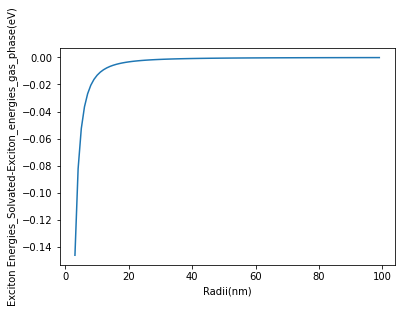

In [66]:
import matplotlib.pyplot as plt

radii=np.arange(3,100)     #generating radii for particle sizes 10 nm to 100 nm
gaps=[exciton_energy_solvated(R)-exciton_energy(R) for R in radii]
plt.plot(radii,gaps)
plt.xlabel("Radii(nm)")
plt.ylabel("Exciton Energies_Solvated-Exciton_energies_gas_phase(eV)")